<h1>Automated Gating with Immunova: Creating a template for PDMC samples</h1>

In [1]:
from immunova.data.project import Project
from immunova.data.mongo_setup import global_init
from immunova.flow.gating.actions import Template
from tqdm import tqdm_notebook, tqdm
from functools import partial
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
global_init()

In [2]:
peritonitis = Project.objects(project_id='Peritonitis').get()

<h2>T Panel Template</h2>

In [3]:
peritonitis.list_fcs_experiments()

['PBMC_T', 'PDMC_T', 'PBMC_M', 'PDMC_M']

In [4]:
pdmc_t = peritonitis.load_experiment('PDMC_T')

In [5]:
t_template = Template(experiment=pdmc_t, sample_id='pd318-01_t')

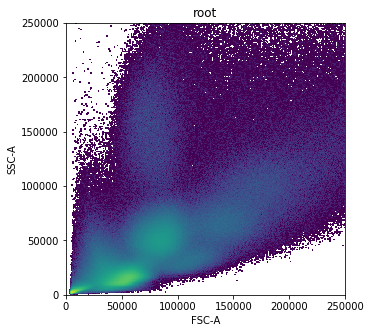

In [6]:
_ = t_template.plot_population('root', x='FSC-A', y='SSC-A')

<h3>Boundary gate</h3>

In [7]:
kwargs=dict(x_min=10000, x_max=125000, y_min=0, y_max=70000)
t_template.create_gate(gate_name='boundary_gate', children=['cells'], parent='root', x='FSC-A',
                      y='SSC-A', func='rect_gate', func_args=kwargs, gate_type='geom')

True

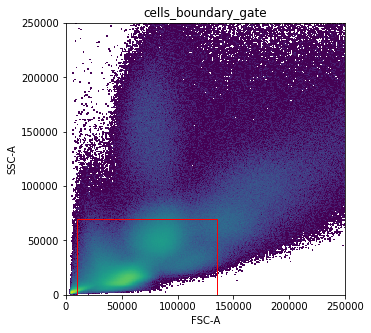

In [8]:
t_template.apply('boundary_gate')

<h3>Lymphocyte gate</h3>

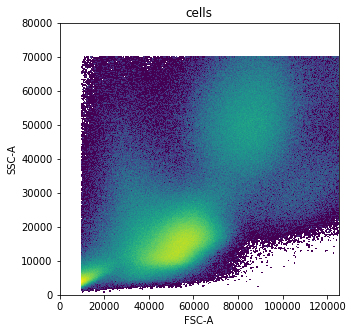

In [9]:
_ = t_template.plot_population('cells', x='FSC-A', y='SSC-A', xlim=(0,125000), ylim=(0,80000))

In [10]:
kwargs=dict(target=(50000,15000), k=4)
t_template.create_gate(gate_name='lymphocyte_gate', children=['lymphocytes'], parent='cells', x='FSC-A',
                      y='SSC-A', func='mm_gate', func_args=kwargs, gate_type='geom')

True

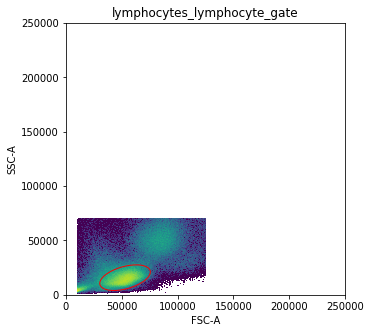

In [11]:
t_template.apply('lymphocyte_gate')

[<Figure size 360x360 with 1 Axes>]

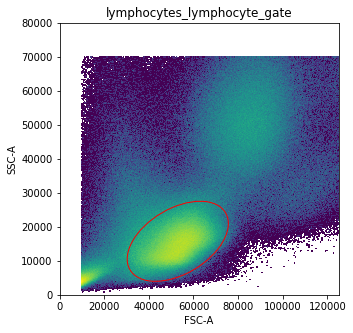

In [12]:
t_template.plot_gate('lymphocyte_gate', xlim=(0,125000), ylim=(0,80000))

<h3>Singlet gate</h3>

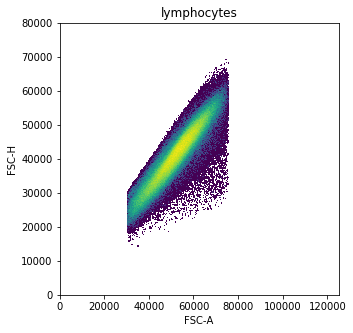

In [13]:
_ = t_template.plot_population('lymphocytes', x='FSC-A', y='FSC-H', xlim=(0,125000), ylim=(0,80000))

In [14]:
kwargs=dict(target=(60000,40000), k=2, conf=0.99)
t_template.create_gate(gate_name='singlet_gate', children=['singlets'], parent='lymphocytes', x='FSC-A',
                      y='FSC-H', func='mm_gate', func_args=kwargs, gate_type='geom')

True

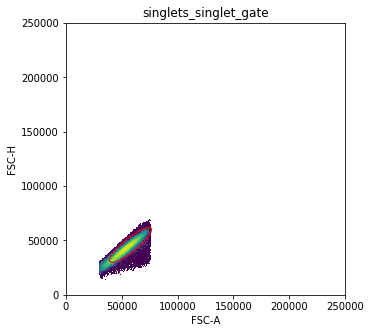

In [15]:
t_template.apply('singlet_gate')

[<Figure size 360x360 with 1 Axes>]

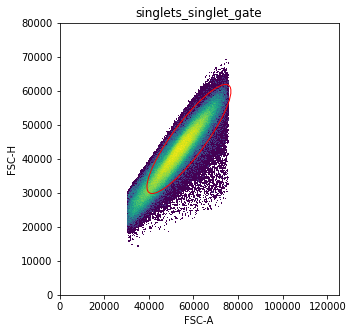

In [16]:
t_template.plot_gate('singlet_gate', xlim=(0,125000), ylim=(0,80000))

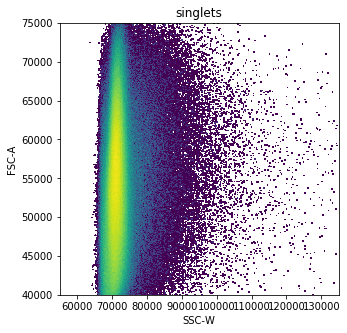

In [18]:
_ = t_template.plot_population('singlets', x='SSC-W', y='FSC-A', xlim=(55000,135000), ylim=(40000,75000))

In [19]:
kwargs=dict(q=0.95)
t_template.create_gate(gate_name='singlet_gate_2', children=['singlets2'], parent='singlets', x='SSC-W',
                       func='quantile_gate', func_args=kwargs, gate_type='geom')

True

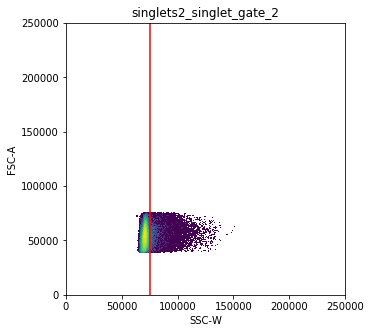

In [20]:
t_template.apply('singlet_gate_2')

[<Figure size 360x360 with 1 Axes>]

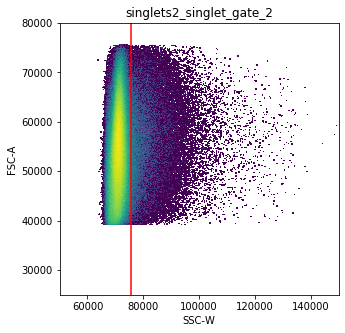

In [21]:
t_template.plot_gate('singlet_gate_2', xlim=(50000,150000), ylim=(25000, 80000))

<h3>Live/Dead Gate</h3>

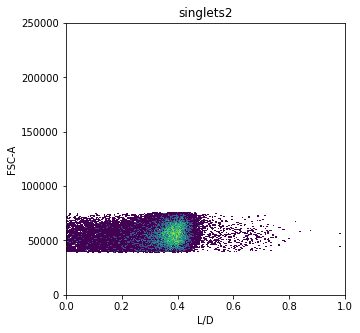

In [22]:
_ = t_template.plot_population('singlets2', x='L/D', y='FSC-A')

In [23]:
kwargs=dict(q=0.95, bool_gate=True, kde_bw=0.1, kde_sample_frac=0.5, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='livedead_gate', children=['live'], parent='singlets2', x='L/D',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

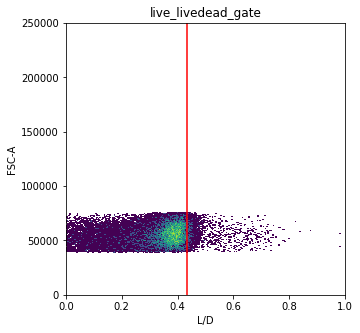

In [24]:
t_template.apply('livedead_gate')

<h3>T Cells (CD3+)</h3>

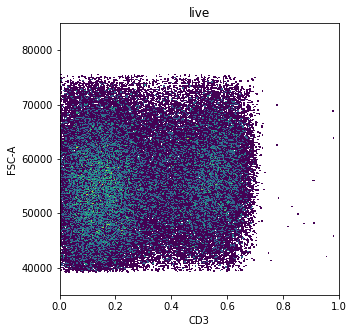

In [25]:
_ = t_template.plot_population('live', x='CD3', y='FSC-A', ylim=(35000,85000))

In [26]:
kwargs=dict(q=0.95, kde_bw=0.1, kde_sample_frac=0.5, ignore_double_pos=True, 
            peak_threshold=0.05)
t_template.create_gate(gate_name='cd3_gate', children=['cd3+'], parent='live', x='CD3',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

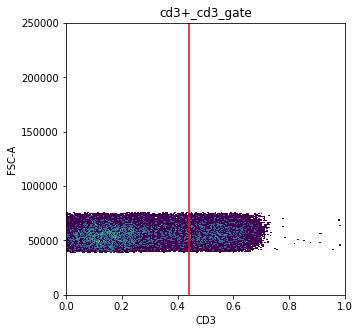

In [27]:
t_template.apply('cd3_gate')

<h3>Gamma Delta T cells</h3>

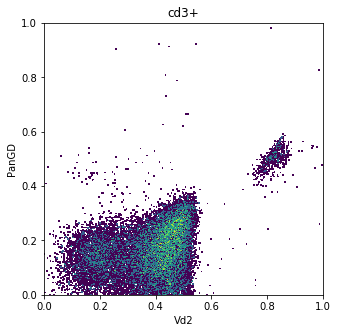

In [28]:
_ = t_template.plot_population('cd3+', x='Vd2', y='PanGD')

In [29]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, expected_populations=[{'id': 'gdt', 'target': (0.9, 0.6)},
                                                                   {'id': 'vd2-', 'target': (0.2, 0.6)},
                                                                   {'id': 'non_gdt', 'target': (0.3, 0.1)}],
            core_only=False)
t_template.create_gate(gate_name='gdt_gate', children=['gdt', 'vd2-', 'non_gdt'], parent='cd3+', x='Vd2',
                       y='PanGD', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


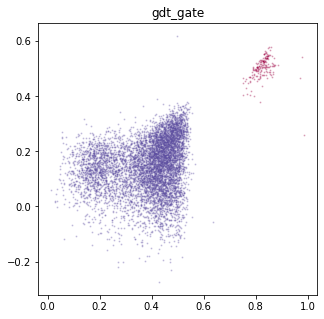

In [30]:
t_template.apply('gdt_gate')

<h3>MAITs</h3>

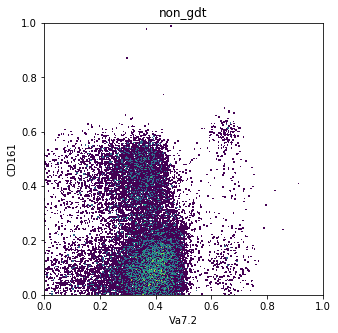

In [33]:
_ = t_template.plot_population('non_gdt', x='Va7.2', y='CD161')

In [42]:
kwargs=dict(min_pop_size=10, distance_nn=0.02, expected_populations=[{'id': 'mait', 'target': (0.8, 0.6)},
                                                                   {'id': 'classic_tcells', 'target': (0.3, 0.3)}],
            core_only=False, nn=10, sampling_method='density', )
t_template.create_gate(gate_name='mait_gate', children=['mait', 'classic_tcells'], parent='non_gdt', x='Va7.2',
                       y='CD161', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


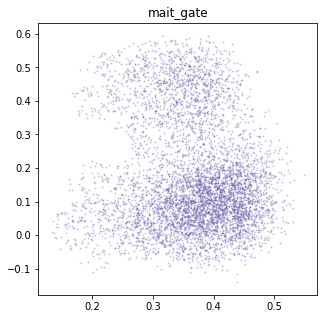

In [43]:
t_template.apply('mait_gate')

In [44]:
t_template.populations

{'root': {'population_name': 'root',
  'prop_of_parent': 1.0,
  'prop_of_total': 1.0,
  'warnings': [],
  'parent': 'NA',
  'children': ['cells'],
  'geom': {},
  'index': array([      0,       1,       2, ..., 5443924, 5443925, 5443926])},
 'cells': {'population_name': 'cells',
  'index': array([      0,       1,       2, ..., 5443921, 5443923, 5443925]),
  'prop_of_parent': 0.7698490446326705,
  'prop_of_total': 0.7698490446326705,
  'parent': 'root',
  'children': ['lymphocytes'],
  'geom': {'x_min': 10000, 'x_max': 125000, 'y_min': 0, 'y_max': 70000}},
 'lymphocytes': {'population_name': 'lymphocytes',
  'index': array([      1,       2,       5, ..., 5443914, 5443916, 5443921]),
  'prop_of_parent': 0.5634533221411013,
  'prop_of_total': 0.4337740017454312,
  'parent': 'cells',
  'children': ['singlets'],
  'geom': {'mean': (52955.57258769108, 15749.335252159392),
   'width': 20451.42122228832,
   'height': 46808.81659070496,
   'angle': 106.13342708452839}},
 'singlets': {'populat